# Imports

In [1]:
import sys
from warnings import filterwarnings

import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
from pdpbox import pdp
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

filterwarnings('ignore')

In [2]:
sys.executable

'/anaconda3/bin/python'

# Data

In [3]:
df = pd.read_csv('../data/FIFA 2018 Statistics.csv')
df.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [4]:
df.shape

(128, 27)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 27 columns):
Date                      128 non-null object
Team                      128 non-null object
Opponent                  128 non-null object
Goal Scored               128 non-null int64
Ball Possession %         128 non-null int64
Attempts                  128 non-null int64
On-Target                 128 non-null int64
Off-Target                128 non-null int64
Blocked                   128 non-null int64
Corners                   128 non-null int64
Offsides                  128 non-null int64
Free Kicks                128 non-null int64
Saves                     128 non-null int64
Pass Accuracy %           128 non-null int64
Passes                    128 non-null int64
Distance Covered (Kms)    128 non-null int64
Fouls Committed           128 non-null int64
Yellow Card               128 non-null int64
Yellow & Red              128 non-null int64
Red                       128 non-nul

In [6]:
kinds = np.array([dt.kind for dt in df.dtypes])

all_num = kinds == 'i'

feature_names = df.columns[all_num]
X = df[feature_names]
y = df['Man of the Match'] == 'Yes'
X.shape, y.shape

((128, 18), (128,))

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=123)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((96, 18), (32, 18), (96,), (32,))

# Model

In [8]:
model = RandomForestClassifier(random_state=123).fit(X_train, y_train)

# Permutation Importance

In [9]:
perm = PermutationImportance(model, random_state=123).fit(X_valid, y_valid)

eli5.show_weights(perm, feature_names=feature_names.tolist())

Weight,Feature
0.0375 ± 0.1212,Goal Scored
0.0312 ± 0.0685,Pass Accuracy %
0 ± 0.0000,Yellow & Red
0 ± 0.0000,Red
0 ± 0.0000,Fouls Committed
-0.0063 ± 0.0468,Passes
-0.0063 ± 0.0250,Goals in PSO
-0.0125 ± 0.0306,Saves
-0.0125 ± 0.0306,Yellow Card
-0.0125 ± 0.0637,On-Target


# Partial Dependence Plots

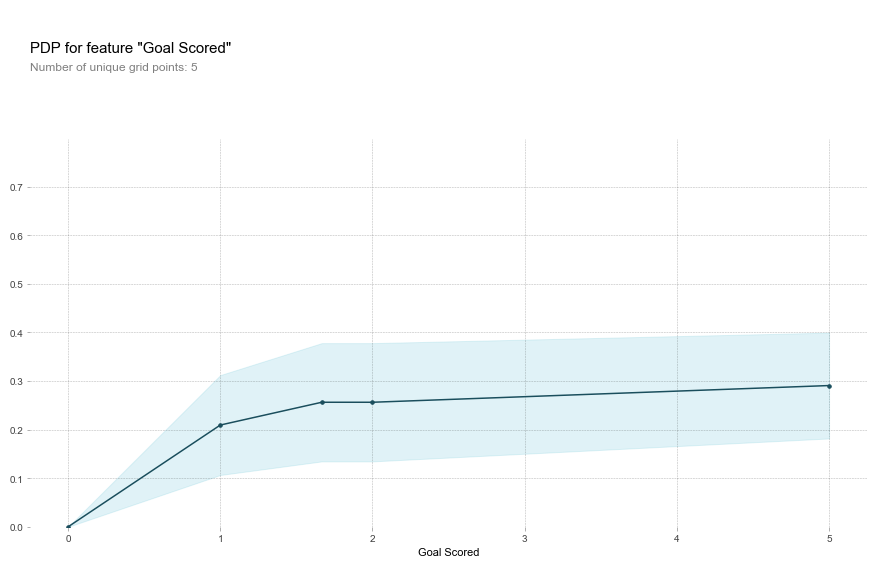

In [10]:
pdp_goals = pdp.pdp_isolate(model, X_valid, model_features=feature_names, feature='Goal Scored')
pdp.pdp_plot(pdp_goals, 'Goal Scored');

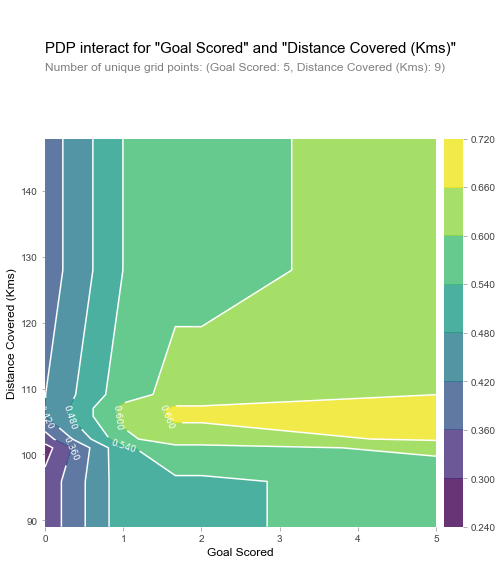

In [11]:
pdp_inter = pdp.pdp_interact(model, X_valid,
                             model_features=feature_names,
                             features=['Goal Scored', 'Distance Covered (Kms)'])
pdp.pdp_interact_plot(pdp_interact_out=pdp_inter,
                      feature_names=['Goal Scored', 'Distance Covered (Kms)'],
                      plot_type='contour');

# SHAP Values

**sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values**

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid[:1])

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_valid[:1])

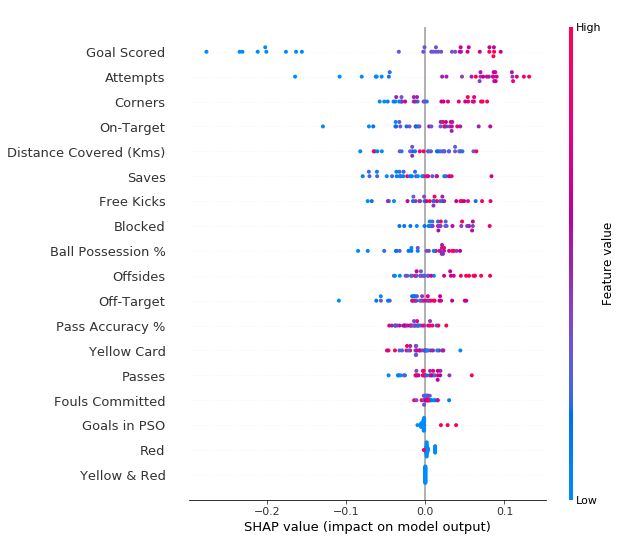

In [20]:
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values[1], X_valid)

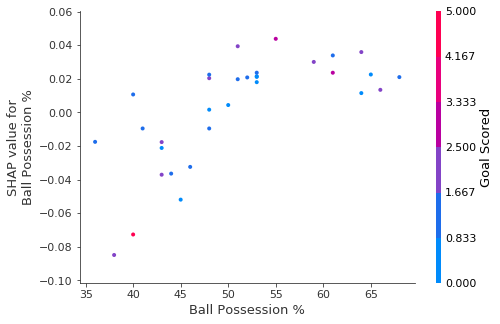

In [22]:
# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X_valid, interaction_index="Goal Scored")

In [26]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_valid)